In [ ]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
from sklearn.impute import SimpleImputer, KNNImputer

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 2 hours**. For this time interval, using the values of the **4 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train a Boosting model for the task. Choose the model based on the number, and type of features available.**



Features:

* Date: Time window of ten minutes.
* Temperature: Weather Temperature.
* Humidity: Weather Humidity.
* WindSpeed: Wind Speed.
* GeneralDiffuseFlows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DiffuseFlows

Target:

SolarPower

## Dataset links:
* [DS1](https://drive.google.com/file/d/1-Pcpb1xWpKc8Cgs-P7xqBFHw2NM0dBsA/view?usp=sharing)
* [DS2](https://drive.google.com/file/d/1-Pul07w6LXpm-uo99qbNc86FHhwl4yQD/view?usp=sharing)

## Read the datasets

In [ ]:
df1 = pd.read_csv('power_consumption_g3.csv')

In [ ]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [ ]:
df1.isnull().sum()

Date          0
SolarPower    0
dtype: int64

In [ ]:
df2 = pd.read_csv("power_consumption_g3_feat.csv")

In [ ]:
df2['Date'] = pd.to_datetime(df2['Date'])

In [ ]:
df2.isnull().sum()

Date                     0
Temperature            559
Humidity               499
WindSpeed              529
GeneralDiffuseFlows    524
DiffuseFlows           505
dtype: int64

In [ ]:
imputer = SimpleImputer(strategy = 'constant',  fill_value = False)

In [ ]:
df2['Temperature'] = imputer.fit_transform([df2['Temperature']])[0]
df2['Humidity'] = imputer.fit_transform([df2['Humidity']])[0]
df2['WindSpeed'] = imputer.fit_transform([df2['WindSpeed']])[0]
df2['GeneralDiffuseFlows'] = imputer.fit_transform([df2['GeneralDiffuseFlows']])[0]
df2['DiffuseFlows'] = imputer.fit_transform([df2['DiffuseFlows']])[0]

In [ ]:
df1.head()

,Date,SolarPower
0,2017-06-22 11:50:00,35818.80795
1,2017-04-24 22:50:00,34628.20237
2,2017-11-05 09:00:00,22781.53846
3,2017-10-19 23:20:00,31925.77681
4,2017-03-25 17:10:00,30246.12766


In [ ]:
df2.head()

,Date,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900


## Merge the datasets (and pre-processing if needed)

In [ ]:
df = df1.merge(df2, how='inner',left_on="Date", right_on="Date")

In [ ]:
df.head()

,Date,SolarPower,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
0,2017-06-22 11:50:00,35818.80795,27.43,33.46,4.924,879.000,48.180
1,2017-04-24 22:50:00,34628.20237,16.93,76.10,0.082,0.015,0.141
2,2017-11-05 09:00:00,22781.53846,17.13,88.70,0.073,180.100,171.200
3,2017-10-19 23:20:00,31925.77681,20.00,86.00,4.920,0.055,0.100
4,2017-03-25 17:10:00,30246.12766,17.18,43.83,0.086,480.600,485.400


In [ ]:
df.isnull().sum()

Date                   0
SolarPower             0
Temperature            0
Humidity               0
WindSpeed              0
GeneralDiffuseFlows    0
DiffuseFlows           0
dtype: int64

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

## Group the datasets into time intervals of 2 hours

In [ ]:
aggregation = {
    'SolarPower': 'mean',
    'Temperature': 'mean',
    'Humidity': 'mean',
    'WindSpeed': 'mean',
    'GeneralDiffuseFlows': 'mean',
    'DiffuseFlows': 'mean'
}

In [ ]:
df_test = df.groupby(pd.Grouper(key="Date", freq="2h")).agg(aggregation)

In [ ]:
df_test.head()

,SolarPower,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
Date,,,,,,
2017-01-01 00:00:00,26927.594937,5.385083,69.808333,0.081917,0.060167,0.105667
2017-01-01 02:00:00,21447.088607,5.029333,78.008333,0.082583,0.061417,0.135083
2017-01-01 04:00:00,20641.518987,4.919667,74.641667,0.081667,0.061917,0.120833
2017-01-01 06:00:00,20094.683545,4.512750,74.575000,0.082417,0.063583,0.122500
2017-01-01 08:00:00,21255.189872,4.632167,73.791667,0.082417,79.281917,15.761833


## Create lags

In [ ]:
df_test.columns

Index(['SolarPower', 'Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows'],
      dtype='object')

In [ ]:
lag = 4
columns = df_test.columns
for i in range(1, lag + 1):
  for col in columns:
    df_test[f'{col}_lag_{i}'] = df_test[col].shift(i)

In [ ]:
df_test.dropna(axis=0, inplace=True)

# Split the dataset into 80% training and 20% testing datasets

In [ ]:
X = df_test.drop(columns=(["SolarPower", "Temperature", "Humidity", "WindSpeed", "GeneralDiffuseFlows", "DiffuseFlows"]))
Y = df_test["SolarPower"]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False, test_size=0.2)

## Create the model, pre-process the data and make it suitable for training

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
params = {
    "n_estimators": np.arange(35,50, 100),
    "max_depth": [3, 5, 7]
}

## Perofrm hyper-parameter optimization with a 5-fold cross validation.

Important: Do not use many values for the hyper-parameters due to time constraints.

KEEP IN MIND THE DATASET IS TIME-SERIES.

In [ ]:
grid_search = GridSearchCV(XGBRegressor(), cv=TimeSeriesSplit(5), param_grid=params)

## Fit the model with the best parameters on the training dataset

In [ ]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [3, 5, 7], 'n_estimators': array([35])})

## Calculate the adequate metrics on the testing dataset

In [ ]:
estimator = grid_search.best_estimator_

In [ ]:
estimator.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=35, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Visualize the targets against the predictions

In [ ]:
preds = estimator.predict(X_test)

In [ ]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(4125057.302841809, 1482.6491067353954, 0.878479050678465)

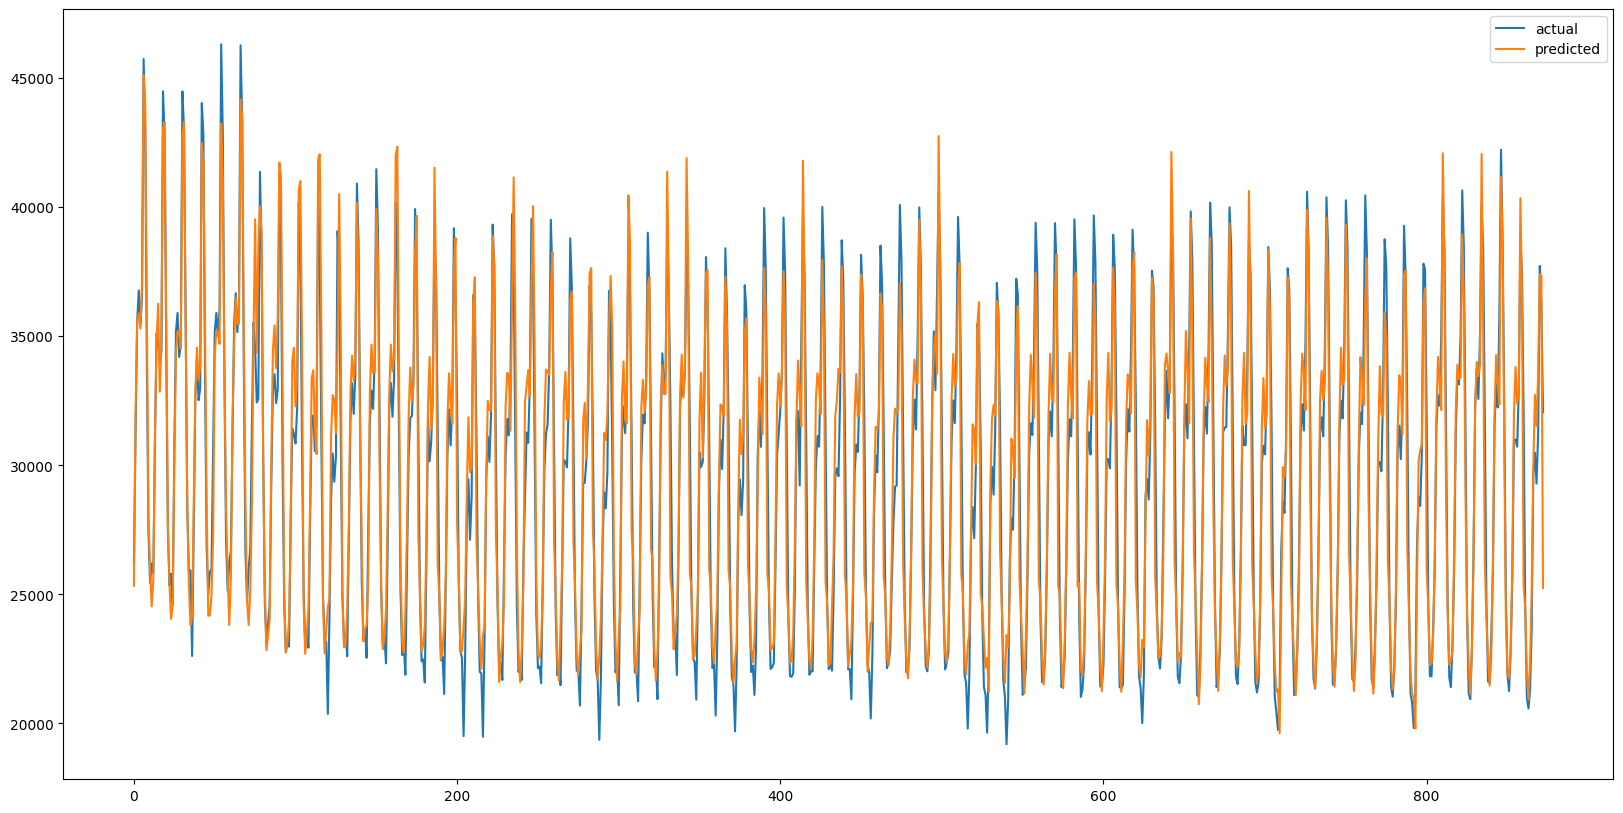

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()